# Methanotrophy

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
from utils import * 
from matrix import *
from norm import * 
from ordinate import *
from plot import *
import os
import pickle

/tmp/ipykernel_340549/1371887863.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
DATA_DIR = '/home/prichter/Documents/data/methanotrophy'

## Loading data

In [4]:
metadata_df = dataframe_from_metadata(os.path.join(DATA_DIR, 'metadata.csv'))
counts_df = dataframe_from_counts(os.path.join(DATA_DIR, 'counts.tsv'))
taxonomy_df = dataframe_from_taxonomy(os.path.join(DATA_DIR, 'taxonomy.tsv'))

print('Fields in metadata.csv:', ', '.join(metadata_df.columns))
print('Fields in counts.tsv:', ', '.join(counts_df.columns))
print('Fields in taxonomy.tsv:', ', '.join(taxonomy_df.columns))

Fields in metadata.csv: sample, serial_code, soil_depth, site, season, flux_ch4, temp_air, temp_soil, water_content, bulk_density
Fields in counts.tsv: asv, sample, count
Fields in taxonomy.tsv: domain, phylum, class, order, family, genus, species, domain_sub, phylum_sub, class_sub, order_sub, family_sub, genus_sub, species_sub, asv


In [5]:
missing_samples = set(counts_df['sample'].values) - set(metadata_df['sample'].values)
print(f"Samples {', '.join(list(missing_samples))} are present in the counts.tsv file, but not in metadata.")
print(f"Dropping {counts_df['sample'].isin(missing_samples).values.sum()} rows in the counts data which do not have associated metadata." )
counts_df = counts_df[~counts_df['sample'].isin(missing_samples)] # Remove rows in counts_df which don't have associated metadata.

# Combine the data across files into a single DataFrame. Drop the samples column, which is redundant with the serial code. 
df = counts_df.merge(metadata_df, on=['sample']).merge(taxonomy_df, on=['asv'], how='left').drop(columns='sample')

# Save the cleaned-up data to a CSV file. 
df.to_csv(f'{DATA_DIR}/data.csv', index=False)

Samples HDK22-KML-sand-wet, HDK22-KML-sand-dry are present in the counts.tsv file, but not in metadata.
Dropping 192136 rows in the counts data which do not have associated metadata.


In [4]:
def create_asv_matrix(df:pd.DataFrame) -> pd.DataFrame:
    '''Convert the DataFrame containing the sample metadata and ASV counts into an ASV table (with columns
    as ASVs, and rows as samples). Each cell contains the raw count for that particular ASV in the sample.''' 
    # Accumulate all of the metadata into a separate DataFrame. 
    metadata = df[[col for col in df.columns if col not in ['count']]]

    df = df[['serial_code', 'asv', 'count']]
    df = df.groupby(by=['serial_code', 'asv']).sum()
    df = df.reset_index() # Converts the multi-level index to categorical columns. 
    df = df.pivot(columns=['asv'], index=['serial_code'], values=['count'])
    # Reset column labels, which were weird because of the multi-indexing. 
    df.columns = df.columns.get_level_values('asv').values

    return AsvMatrix(df, metadata=metadata)

## Analysis

In [6]:
# Generating the count matrix is currently extremely slow. Possibly a way to speed it up?
asv_matrix = create_asv_matrix(pd.read_csv(f'{DATA_DIR}/data.csv'))
asv_matrix.filter_read_depth(5000)

with open('asv_matrix.pkl', 'wb') as f:
    pickle.dump(asv_matrix, f)

matrices.CountMatrix.filter_read_depth: Discarding 2 samples with read depth less than 5000.


NameError: name 'pickle' is not defined

In [12]:
tm = m.get_taxonomy_matrix()

norm = ConstantSumScaling()
norm(tm)

In [13]:
tm.shape()

(32, 28)

In [14]:
nmds = NonmetricMultidimensionalScaling(n_components=2, metric='bray-curtis')
nmds.fit(tm)

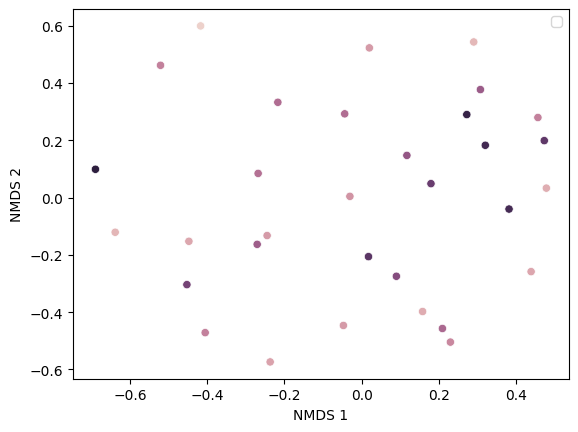

In [16]:
plot_nonmetric_multidimensional_scaling(nmds, labels=tm.get_metadata('flux_ch4'))
plt.savefig('/home/prichter/Documents/methanotrophy/figures/nmds_flux_ch4.png')

In [12]:
ca.col_label        print(sample_metadata)s

array(['Abditibacteriota', 'Acidobacteriota', 'Actinobacteriota',
       'Amorphea', 'Archaeplastida', 'Armatimonadota', 'Bacteria',
       'Bacteroidota', 'Bdellovibrionota', 'Chloroflexi', 'Crenarchaeota',
       'Cyanobacteria', 'Deinococcota', 'Dependentiae',
       'Desulfobacterota', 'Elusimicrobiota', 'Entotheonellaeota',
       'Fibrobacterota', 'Firmicutes', 'Gemmatimonadota', 'Halobacterota',
       'Harosa', 'Latescibacterota', 'MBNT15', 'Methylomirabilota',
       'Myxococcota', 'Nitrospirota', 'Patescibacteria',
       'Planctomycetota', 'Proteobacteria', 'RCP2-54', 'Root',
       'Sumerlaeota', 'Thermoplasmatota', 'Verrucomicrobiota', 'WPS-2',
       'WS2'], dtype=object)